<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#LogisticRegression" data-toc-modified-id="LogisticRegression-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>LogisticRegression</a></span></li><li><span><a href="#CatBoostClassifier" data-toc-modified-id="CatBoostClassifier-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>CatBoostClassifier</a></span></li><li><span><a href="#SGDClassifier" data-toc-modified-id="SGDClassifier-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>SGDClassifier</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
import torch
import transformers
from tqdm import notebook
from tqdm import tqdm
import nltk
import re
from pymystem3 import Mystem
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.utils import resample
from sklearn.utils import shuffle
import warnings
warnings.filterwarnings("ignore")

In [2]:
df_comments = pd.read_csv('/datasets/toxic_comments.csv')

Приведем текст к нижнему регистру

In [3]:
df_comments['text'] = df_comments['text'].str.lower()

Отбор случайных образцов из набора данных

In [4]:
df_comments.head()

,text,toxic
0,explanation\nwhy the edits made under my usern...,0
1,d'aww! he matches this background colour i'm s...,0
2,"hey man, i'm really not trying to edit war. it...",0
3,"""\nmore\ni can't make any real suggestions on ...",0
4,"you, sir, are my hero. any chance you remember...",0


In [5]:
df_comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
text     159571 non-null object
toxic    159571 non-null int64
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


Изучим соотношение классов целевого признака

In [6]:
m = df_comments['toxic'].value_counts() 
m

0    143346
1     16225
Name: toxic, dtype: int64

In [7]:
df_comments = df_comments.sample(frac=0.11).reset_index(drop=True)

Имеется сильный дисбаланс классов - 1:9

In [8]:
lemmatizer = WordNetLemmatizer()
tqdm.pandas()

# напишем функцию для лемматизации и очистки текста
def lemm_clear_text(text):
    clear_list = re.sub(r'[^A-Za-z]', ' ', text) #оставляем только латинские символы
    word_list = nltk.word_tokenize(clear_list) # разбиваем входной текст на токены(слова)
    lemm_text = ' '.join([lemmatizer.lemmatize(w) for w in word_list]) # лемматизируем каждое слово и объединяем в строку
    return " ".join(clear_list.split()) #функция возвращает очищенный и лемматизированный текст в виде строки
 
# применим функцию к нашим комментариям и создадим столбец, хранящий лемматизированные предложения
df_comments['lemm_text'] = df_comments['text'].progress_apply(lambda x: lemm_clear_text(x))

100%|██████████| 17553/17553 [00:18<00:00, 928.55it/s] 


Создадим корпус сбалансированных данных

In [9]:
corpus_downsampled = df_comments['lemm_text'].values.astype('U')
target_downsampled = df_comments['toxic']

Разделим данные на тестовую и обучающую выборки

In [10]:
corpus_train, corpus_test, target_train, target_test = train_test_split(corpus_downsampled,
                                                                        target_downsampled,
                                                                        test_size=0.2,
                                                                        random_state=12345)

Применим метод повторной выборки для передискретизации класса меньшинства

In [11]:
df_comments_train = df_comments.iloc[target_train.index]

target_train_class_zero = df_comments_train[df_comments_train['toxic'] == 0]['toxic']
target_train_class_one = df_comments_train[df_comments_train['toxic'] == 1]['toxic']
target_train_class_zero_downsample = target_train_class_zero.sample(target_train_class_one.shape[0],
                                                                    random_state=12082020)
target_train_downsample = pd.concat([target_train_class_zero_downsample, target_train_class_one])

features_train_downsample = df_comments.iloc[target_train_downsample.index]
features_train_downsample, target_train_downsample = resample(features_train_downsample,
                                                             target_train_downsample,
                                                             replace=False, 
                                                             n_samples=None,
                                                             random_state=123)
df_downsampled = pd.concat([features_train_downsample, target_train_downsample])
df_downsampled['toxic'].value_counts()

1.0    1383
0.0    1383
Name: toxic, dtype: int64

Данные сбалансированны

Проверим пропуски

In [12]:
df_comments.isnull().sum()

text         0
toxic        0
lemm_text    0
dtype: int64

Удалим ненужные переменные

In [13]:
del df_comments_train
del df_downsampled
del target_train_class_zero
del target_train_class_one
del target_train_class_zero_downsample
del target_train_downsample
del features_train_downsample

In [14]:
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

count_tf_idf = TfidfVectorizer(min_df=2,stop_words=stopwords)
count_tf_idf.fit(corpus_train)
 
features_train = count_tf_idf.fit_transform(corpus_train).toarray()
features_test = count_tf_idf.transform(corpus_test).toarray()

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Обучение

Создаем словарь для результатов тестирования

In [15]:
test_score = {}

### LogisticRegression

In [16]:
model_lr = LogisticRegression(solver='liblinear', random_state=27).fit(features_train, target_train)

predictions = model_lr.predict(features_train)
f1_train_lr = f1_score(target_train, predictions)
f1_train_lr

0.5857142857142857

In [17]:
predictions_test = model_lr.predict(features_test)
f1_test_lr = f1_score(target_test, predictions_test)
f1_test_lr

0.5485961123110151

In [18]:
test_score['LogisticRegression1'] = [f1_train_lr, f1_test_lr]

In [62]:
model_log=LogisticRegression(n_jobs=-1, random_state=27).fit(features_train,target_train)

print("f1 для теста до подбора гиперпараметров:",f1_score(model_log.predict(features_test),target_test))


from sklearn.model_selection import GridSearchCV

param_grid= [
    {'C':[5, 10, 15],
     'n_jobs': [-1,1]},
    {'C': np.logspace(-5, 0, 8)}
]
    
     
grid_model_reg = GridSearchCV(model_log, param_grid, cv=3, n_jobs=-1,scoring='f1')

grid_model_reg.fit(features_train, target_train)

print("Tuned Logistic Regression Parameters: {}".format(grid_model_reg.best_params_)) 

print("Best F1 score is {}".format(grid_model_reg.best_score_))

f1 для теста до подбора гиперпараметров: 0.5485961123110151
Tuned Logistic Regression Parameters: {'C': 15, 'n_jobs': -1}
Best F1 score is 0.6564271986313756


In [71]:
model_log_cv=LogisticRegression(n_jobs=-1,C=15, class_weight = 'balanced', random_state=27).fit(features_train,target_train)

In [72]:
f1_line=f1_score(model_log_cv.predict(features_test),target_test)

In [73]:
print("f1:",round(f1_line,2))

f1: 0.75


In [74]:
test_score['LogisticRegression2'] = [f1_score(model_log.predict(features_test),target_test), f1_line]

### CatBoostClassifier

In [ ]:
model_cat = CatBoostClassifier(loss_function= 'Logloss', 
                               iterations=300,
                               eval_metric='F1',
                               random_state=42)

model_cat.fit(features_train, target_train, verbose=50)
prediction = model_cat.predict(features_train)

f1_train_cat = f1_score(target_train, predictions)
f1_train_cat

predictions_test = model_cat.predict(features_test)
f1_test_cat = f1_score(target_test, predictions_test)
f1_test_cat

test_score['CatBoostClassifier'] = [f1_train_cat, f1_test_cat]

### SGDClassifier

In [75]:
model_SGD = SGDClassifier(shuffle=True, random_state=27)
model_SGD.fit(features_train, target_train)
prediction = model_SGD.predict(features_train)
f1_train_SGD = f1_score(target_train, prediction)
f1_train_SGD

0.7577250335871025

In [76]:
predictions_test = model_SGD.predict(features_test)
f1_test_SGD = f1_score(target_test, predictions_test)
f1_test_SGD

0.6332665330661323

In [88]:
test_score['SGDClassifier'] = [f1_train_SGD, f1_test_SGD]

## Выводы

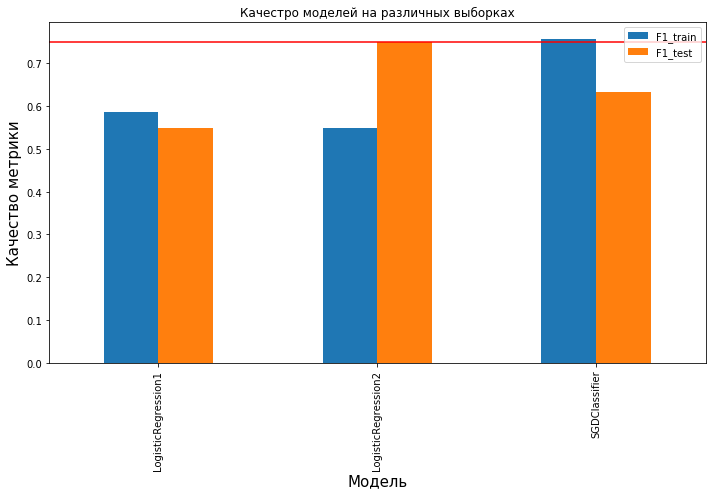

In [94]:
plt.figure(figsize=(10, 7))
plt.subplot(111)
df_score.plot(kind='bar', ax=plt.gca()).hlines(0.75, -1, 5,
                                              color = 'r')
plt.xlabel('Модель', fontsize=15)
plt.ylabel('Качество метрики', fontsize=15)
plt.title('Качестро моделей на различных выборках')

plt.tight_layout()

Подготовлены данные для обучения на моделях.
Выбран способ баланса классов, поделены данные на обучающую и тестовою выборку.
Показаны параметры качества моделей.
все использованные модели показали результат выше необходимого, но тестовой выбоке по метрике F1 эффективнее всего себя показала SGDClassifier. Данная модель обладает лучшими показателями Precision и Accuracy.

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]   Данные загружены и подготовлены
- [x]  Модели обучены
- [x]  Значение метрики *F1* не меньше 0.75
- [x]  Выводы написаны